In [11]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from ideas import intersection_over_union
from ideas import al
from ideas import aw

box_columns = ['Xmin','Ymin','Xmax','Ymax']

def weighted_averaging(iid, df, np_data, avg):
    items = df[df['itemId'] == iid]
    vi = np_data[items.index.values]
    if vi.shape[0] == 0:
        return
    l = al(vi)
    w = aw(vi)
    sabx = (l * w) ** 2
    sb = sum(1 / sabx)
    for y in range(0, 4):        
        avg.loc[iid][y] = sum(vi[:,y] / sabx) / sb
    avg.loc[iid][4] = iid
    return avg.loc[iid]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

In [65]:
te_d = pd.read_csv('train_data.csv')
t_a = pd.read_csv('train_answers.csv')
ids = list(set(te_d['itemId']))
te_d['area'] = (te_d['Xmax'] - te_d['Xmin'])*(te_d['Ymax'] - te_d['Ymin'])
te_d_max = te_d[['area', 'itemId']].groupby('itemId').max()
te_d = te_d.merge(te_d_max, on=['itemId'])
te_d['area_ratio'] = te_d['area_x']/te_d['area_y']
te_d_r = te_d[te_d['area_ratio'] > .75][box_columns + ['itemId']]
te_d_r = te_d_r.reset_index()
np_te_d = te_d_r[box_columns].values

In [ ]:
te_d['Xcenter'] = (te_d['Xmax'] - te_d['Xmin'])/2
te_d['Ycenter'] = (te_d['Ymax'] - te_d['Ymin'])/2
te_d['h/w'] = 0
for i, row in te_d.iterrows():
    minA = min(row['Xmax'] - row['Xmin'],row['Ymax'] - row['Ymin'])
    maxB = max(row['Xmax'] - row['Xmin'],row['Ymax'] - row['Ymin'])    
    if maxB == 0:
        te_d.iloc[i]['h/w'] = 0
    else:
        te_d.iloc[i]['h/w'] = minA/maxB   

In [ ]:
te_d

In [66]:
te_d_wa = pd.DataFrame(np.zeros((len(ids), 5), dtype=int), 
                      index=ids, columns=['Xmin','Ymin','Xmax','Ymax', 'itemId'])
for iid in ids:
    weighted_averaging(iid, te_d_r, np_te_d, te_d_wa)
    
te_d_wa.to_csv('train_data_wav.csv', index=False)

In [67]:
data = te_d_wa.merge(t_a, on=['itemId'])
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
print(data["iou"].mean()) 

0.5645062692039243


In [13]:
iidd = te_d[te_d['itemId'] == iid][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
iidd_adj = te_d[te_d['itemId'] == iid]
uids = list(set(iidd_adj['userId']))
for i, row in iidd_adj.iterrows():
    uajd = users_adj.loc[row['userId']]
    l = row['Xmax'] - row['Xmin']
    w = row['Ymax'] - row['Ymin']
    for y in box_columns:        
        t = l if "X" in y else w
        c = 1 if "min" in y else -1
        row[y] = row[y] + c * t * uajd[y + 'DifPer']
iidd_ans = iidd_adj[['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]

(838, 1123)

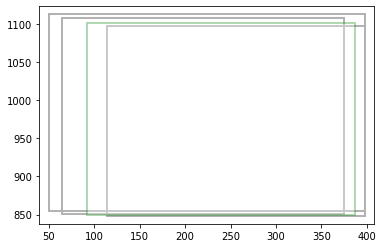

In [149]:
iidd = te_d[te_d['itemId'] == iid][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
iidd_ans = te_d_wa[te_d_wa['itemId'] == iid][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]

tdv = []
tdc = []
tav = []
tac = []

Xmin,Ymin = 2000, 2000
Xmax,Ymax = 0, 0

def minMax(row, y):
    global Xmin,Xmax,Ymin,Ymax    
    Xmin = min(Xmin, row.iloc[y])
    Ymin = min(Ymin, row.iloc[y + 1])
    Xmax = max(Xmax, row.iloc[y])
    Ymax = max(Ymax, row.iloc[y + 1])

for i, row in iidd.iterrows():
    for y in range(0,10,2):
        minMax(row, y)
        tdv.append((row.iloc[y], row.iloc[y + 1]))
        tdc.append(codes[y//2])

for i, row in iidd_ans.iterrows():
    for y in range(0,10,2):
        minMax(row, y)
        tav.append((row.iloc[y], row.iloc[y + 1]))
        tac.append(codes[y//2])

# tobj = quorum.loc[obj][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
# for y in range(0,10,2):
#     minMax(tobj, y)
#     qv.append((tobj.iloc[y], tobj.iloc[y + 1]))
#     qc.append(codes[y//2])    
    
fig, ax = plt.subplots()
ax.add_patch(patches.PathPatch(Path(tdv, tdc), alpha=.3, facecolor='white', edgecolor='black', lw=2))
ax.add_patch(patches.PathPatch(Path(tav, tac), alpha=.3, facecolor='white', edgecolor='green', lw=2))

# ax.add_patch(patches.PathPatch(Path(qv, qc), facecolor='white', edgecolor='red', lw=2))

ax.set_xlim(Xmin - 10, Xmax + 10)
ax.set_ylim(Ymin - 10, Ymax + 10) 